In [1]:
import matplotlib.pyplot as plt
import numpy as np  

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, GPT2LMHeadModel

/lustre/hpc/pheno/inar/mambaforge/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# model = GPT2LMHeadModel.from_pretrained("gpt2")

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [01:12<00:00, 36.14s/it]


### Get unembedding matrix and its pseudo-inverse

In [5]:
#Where is it documented?
# Check if works for all models 
unembed = model.get_output_embeddings().weight.detach()

In [6]:
vocab_size, hidden_dim = unembed.shape
vocab_size, hidden_dim

(32000, 4096)

In [9]:
embed = model.get_input_embeddings().weight.detach()

In [36]:
tokenizer.encode("flipmes")

[1, 19071, 4137]

In [33]:
model.model.norm(embed[708])

tensor([ 4.2009, -1.7153, -1.1853,  ..., -1.3352,  2.4171, -0.1193],
       grad_fn=<MulBackward0>)

In [37]:
# values, indices = torch.topk(unembed @ model.transformer.ln_f(embed[tokenizer.encode(" John")[0]]),k = 20)
# print(values)
# print(indices)
# tokenizer.decode(indices)

values, indices = torch.topk(unembed @ model.model.norm(embed[19071]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([3.9330, 3.9187, 3.5145, 3.4535, 3.4339, 3.3890, 3.3555, 3.3069, 3.2932,
        3.2543, 3.2191, 3.2017, 3.1988, 3.1984, 3.1867, 3.1293, 3.1275, 3.1248,
        3.1170, 3.1136], grad_fn=<TopkBackward0>)
tensor([ 5898,  6175,   683, 23827, 20099, 12239,  5882, 15998, 31925, 11826,
        12883,  7784, 10801, 21349,  1650, 24300, 27909, 26623, 23396, 21301])


'dulekr evachikkavalarpLOB‟essa ki externoral hiringral zaw Namesoden teníanett'

In [7]:
32000 * 4096 * 4 / 1024 / 1024 / 1024

0.48828125

In [15]:
# cross check
inputs = tokenizer("This is a test", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"], output_hidden_states=True)

test_logits = outputs.logits.detach()
explicit_logits = outputs.hidden_states[-1] @ unembed.T

assert torch.allclose(test_logits, explicit_logits)

In [16]:
Wai = unembed.numpy()
pinvWai = np.linalg.pinv(Wai) 

In [17]:
np.allclose(pinvWai @ Wai, np.eye(hidden_dim), atol = 1e-6)

True

In [38]:
tokenizer.encode(" mind")

[1, 28705, 2273]

In [37]:
values, indices = torch.topk(torch.tensor(Wai @ pinvWai[:,2273]),k = 20)
print(values)
print(indices)
tokenizer.decode(indices)

tensor([0.1524, 0.1080, 0.1035, 0.0775, 0.0639, 0.0264, 0.0188, 0.0179, 0.0165,
        0.0164, 0.0162, 0.0162, 0.0153, 0.0127, 0.0125, 0.0121, 0.0116, 0.0114,
        0.0109, 0.0108])
tensor([ 2273, 14683, 15471, 14898, 25117,  6387,  7237,  4498, 29574,  8057,
        31753, 16223,  3031, 16508,  6757, 16842, 29462, 24335,  5523,  5108])


'mind Mindmind mindsminded brain soul ment心 mental脑 jaw heart consciousnessscious imagination意 mentally psy mouth'

In [34]:
maxps1 = []
maxps200 = []
norm = -100.0
for idx in range(hidden_dim):
    maxps1.append(F.softmax(norm * F.one_hot(torch.tensor(idx), num_classes=hidden_dim) @ unembed.T, dim=-1).max())

norm = 200.0
for idx in range(hidden_dim):
    maxps200.append(F.softmax(norm * F.one_hot(torch.tensor(idx), num_classes=hidden_dim) @ unembed.T, dim=-1).max())

Text(0.5, 1.0, 'Max Probabilities for basis directions, Mistral')

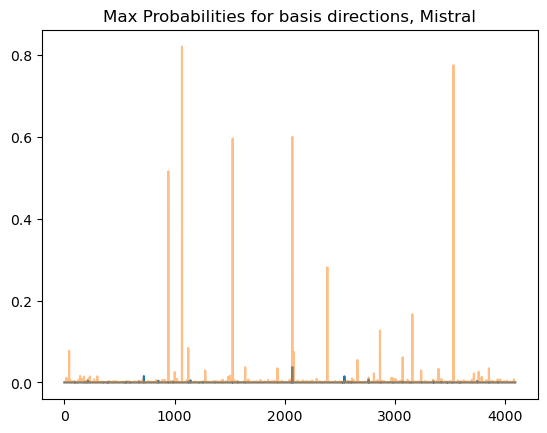

In [38]:
plt.plot(maxps1)  
plt.plot(maxps200, alpha=0.5)  
plt.title('Max Probabilities for basis directions, Mistral')

### Iso-Logit vector

This vector is mapped into $\ell_i = 1$. If added to any logit, it doesn't change the probability distribution

$$ p_i = \exp(\ell_i - F), \; F = - \log(Z) $$

Any constant shift $\ell_i \to \ell_i +C$ is abosrbed in F and doesn't change the probability distribution.



In [13]:
iso_vec = pinvWai @ np.ones(vocab_size)

In [14]:
iso_tensor = torch.tensor(iso_vec, dtype=torch.float32)

In [20]:
iso_logits = iso_tensor @ unembed.T
iso_p = F.softmax(iso_logits, dim=-1)

iso_p.sum(), iso_p.max()*vocab_size, iso_p.std()*vocab_size

(tensor(1.0000), tensor(3.2219), tensor(0.1616))

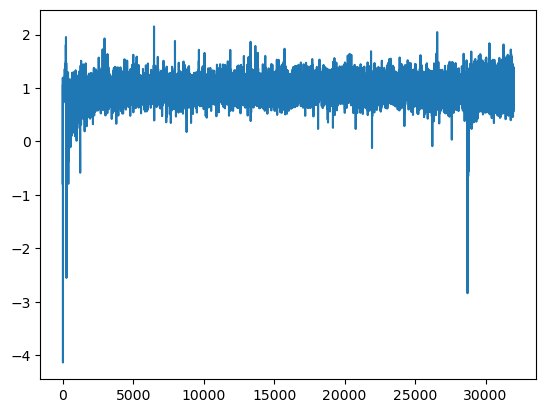

In [53]:
plt.plot(iso_logits)

In [22]:
topk_iso_comp = torch.topk(iso_tensor.abs(),5)
topk_iso_comp

torch.return_types.topk(
values=tensor([28.9464, 26.9456, 24.5323, 16.8218, 15.7275]),
indices=tensor([1375,   53, 1125,  835,   93]))

In [47]:
iso_candidates = []
for i, v in zip(topk_iso_comp.indices, topk_iso_comp.values):
    if v > 0.5:
        iso_candidate = torch.zeros(hidden_dim)
        iso_candidate[i] = iso_tensor[i]
        iso_candidates.append(iso_candidate)

In [48]:
for candidate in iso_candidates:
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    print(candidate_p.max()*vocab_size, candidate_p.std()*vocab_size)

tensor(1.6845) tensor(0.1025)
tensor(1.5215) tensor(0.1267)
tensor(2.9006) tensor(0.1589)
tensor(1.4777) tensor(0.0619)
tensor(1.7092) tensor(0.0660)


In [49]:
test_logits.shape

torch.Size([1, 5, 32000])

In [50]:
for logits in test_logits[0]:
    ptt = F.softmax(logits, dim=-1)
    print(ptt.max()*vocab_size, ptt.std()*vocab_size)

tensor(9057.3135) tensor(55.2602)
tensor(6912.3027) tensor(45.2023)
tensor(10427.5703) tensor(74.5421)
tensor(1960.4727) tensor(18.0274)
tensor(5597.8765) tensor(45.9302)


In [54]:
max_ps = []
ps_std = []
for i in range(hidden_dim):
    candidate = torch.zeros(hidden_dim)
    candidate[i] = 20.0
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    max_ps.append(candidate_p.max())
    ps_std.append(candidate_p.std())

    

In [44]:
max_ps[-1]

1.4021009

In [57]:
max_ps = np.array(max_ps)
ps_std = np.array(ps_std)

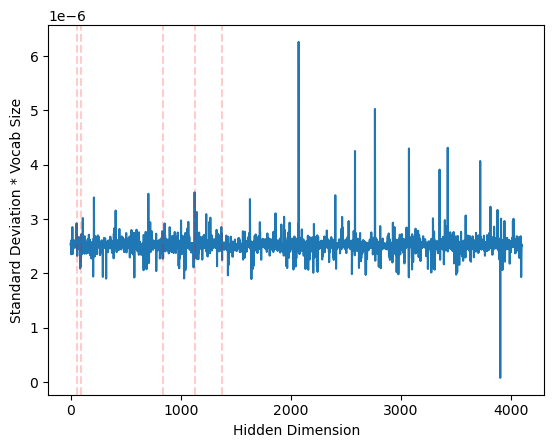

In [58]:
plt.plot(ps_std)
# add hline at iso_p.std()*vocab_size
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.2, label = 'iso candidates')
# plt.hlines(iso_p.std()*vocab_size, 0, hidden_dim, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Hidden Dimension')
plt.ylabel('Standard Deviation * Vocab Size')

plt.show()

Text(0, 0.5, 'max probability*vocab_size')

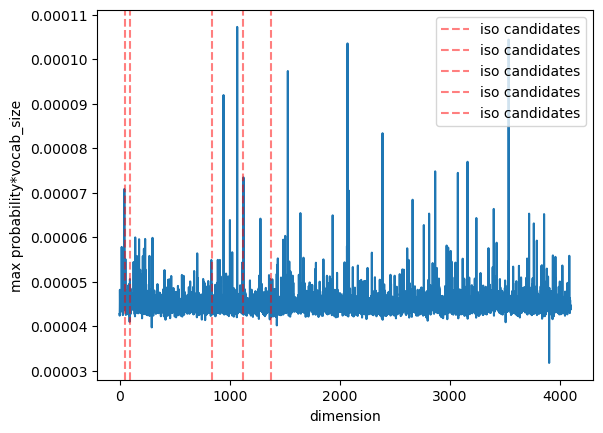

In [59]:
plt.plot(max_ps)
# add vertical lines at topk_iso_comp.indices
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.5, label = 'iso candidates')
plt.legend()
plt.xlabel('dimension')
plt.ylabel('max probability*vocab_size')

# Plotting activations

In [19]:
text1 = "Tom and Lily were playing with their toys in the living room. They liked to build towers and bridges with their blocks and cars. "

In [32]:
inputs.input_ids.shape

torch.Size([1, 30])

In [20]:
inputs = tokenizer(text1, return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"], output_hidden_states=True)

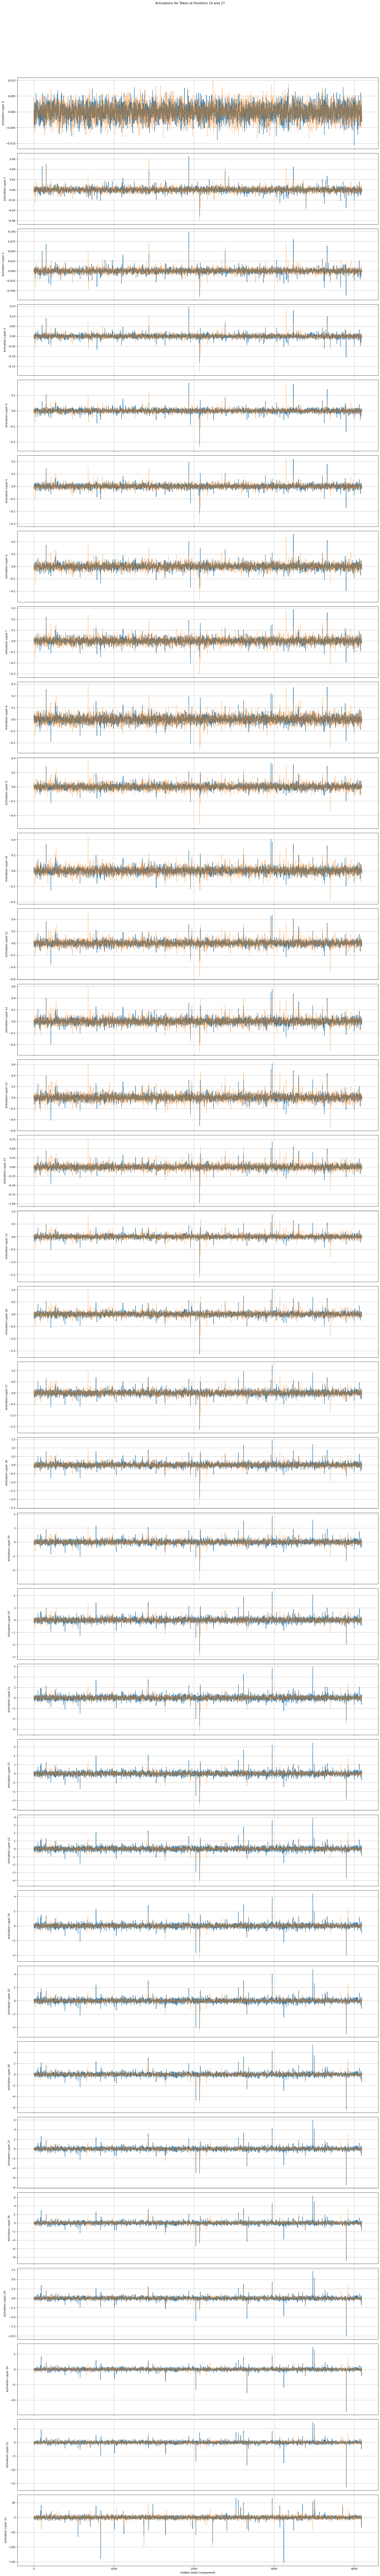

In [40]:

# Extract the hidden states
hidden_states = outputs.hidden_states

# Choose the token position k (e.g., k=10 for the eleventh token)
k = 14
k2 = 27

# Determine the number of layers
n_layers = len(hidden_states)

# Set up the figure and array of subplots
fig, axs = plt.subplots(n_layers, 1, figsize=(20, n_layers * 4), sharex=True)

# Iterate over each layer to plot the hidden states for token k
for i, layer_hidden_states in enumerate(hidden_states):
    # Extract the hidden states for token k in this layer
    token_hidden_states = layer_hidden_states[0, k].detach().numpy()
    token_hidden_states2 = layer_hidden_states[0, k2].detach().numpy()

    # Plot the hidden states for this layer
    
    # if i > 11:
    #     axs[i].plot(token_hidden_states+72*pinvWai @ np.ones(50257))
    # else:
    axs[i].plot(token_hidden_states)
    axs[i].plot(token_hidden_states2, alpha = 0.5)


    # axs[i].set_title(f'Layer {i} - Token {k} Hidden States')
    axs[i].set_ylabel(f'Activation Layer {i}')
    axs[i].grid(True)
    # plt.plot(-pinvWai @ np.ones(50257))


# Set common X axis properties
axs[-1].set_xlabel('Hidden State Components')
fig.suptitle(f'Activations for Token at Positions {k} and {k2}', y=1.02)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.99)  # Adjust the top margin to fit the super title

# Display the plot
plt.show()
